## Accessing EarthCODE Data

### Packages

As best practices dictate, we recommend that you install and import all the necessary libraries at the top of your Jupyter notebook.

In [2]:
from pystac.extensions.storage import StorageExtension
from datetime import datetime

from pystac_client import Client as pystac_client
from odc.stac import configure_rio, stac_load

import pystac
import xarray

from datetime import timedelta
import pandas as pd
import shapely


import hvplot.xarray


In [6]:
import geopandas as gpd
epsg = 4326 # our data's projection

gdf = gpd.read_file("../aoi/feature.geojson")
gdf = gdf.set_crs(epsg=epsg)
gdf.explore()

# What is STAC?

**(summarised from https://stacspec.org/en/tutorials/intro-to-stac/)**

The SpatioTemporal Asset Catalog (STAC) specification was designed to establish a standard, unified language to talk about geospatial data, allowing it to be more easily searchable and queryable.

STAC has been designed to be simple, flexible, and extensible. STAC is a network of JSON files that reference other JSON files, with each JSON file adhering to a specific core specification depending on which STAC component it is describing. This core JSON format can also be customized to fit differing needs, making the STAC specification highly flexible and adaptable.

Therefore, if the STAC specification seems 'light', that is because it is light-- by design. Through this flexibility, different domains and tools can easily utilize the STAC specification and make it their own.

The Extensions section of the spec is where the community collaborates on more detail about specific data types and new functionality.

**NOTE** STAC helps you catalog and describe at a higher level.


## What is STAC

The SpatioTemporal Asset Catalog (STAC) specification was designed to establish a standard, unified language to talk about geospatial data, allowing it to be more easily searchable and queryable.

STAC has been designed to be simple, flexible, and extensible. STAC is a network of JSON files that reference other JSON files, with each JSON file adhering to a specific core specification depending on which STAC component it is describing. This core JSON format can also be customized to fit differing needs, making the STAC specification highly flexible and adaptable.

Therefore, if the STAC specification seems 'light', that is because it is light-- by design. Through this flexibility, different domains and tools can easily utilize the STAC specification and make it their own.

The Extensions section of the spec is where the community collaborates on more detail about specific data types and new functionality.

### What is a SpatioTemporal Asset

A SpatioTemporal Asset is any file that represents information about the Earth captured in a certain place and at a particular time. Examples include spatiotemporal data derived from imagery (from satellites, airplanes, and drones), Synthetic Aperture Radar (SAR), point clouds (from LiDAR, structure from motion, etc.), data cubes, and full-motion video. The key is that the GeoJSON is not the actual 'thing', but instead references files and serves as an index to the STAC Assets.




# STAC Components
There are three component specifications that together make up the core SpatioTemporal Asset Catalog specification. These components are:

1. Item - A STAC Item is the foundational building block of STAC. It is a GeoJSON feature supplemented with additional metadata that enables clients to traverse through catalogs. Since an item is a GeoJSON, it can be easily read by any modern GIS or geospatial library. One item can describe one or more SpatioTemporal Asset(s). For example, a common practice of using STAC for imagery is that each band in a scene is its own STAC Asset and there is one STAC Item to represent all the bands in a single scene.

2. Catalog - A Catalog is usually the starting point for navigating a STAC. A catalog.json file contains links to some combination of other STAC Catalogs, Collections, and/or Items. We can think of it like a directory tree on a computer.


3. Collection - A STAC Collection builds upon the STAC Catalog specification to include additional metadata about a set of items that exist as part of the collection. It extends the parent catalog by adding additional fields to enable the description of information like the spatial and temporal extent of the data, the license, keywords, providers, etc. Therefore, it can easily be extended for additional collection-level metadata.

Each component can be used alone, but they work best in concert with one another.

![stac](../static/stacsetup.png)

A STAC Item represents one or more spatiotemporal assets as GeoJSON so that it can be easily searched. The STAC Catalog specification provides structural elements to group STAC Items and Collections. STAC Collections are catalogs that add more required metadata and describe a group of related items. Now, let's dive into each one of these components a bit more in-depth.

The STAC API specification builds on top of that core and allows us to do dynamic queries over our collections.

# Accessing the EarthCODE Catalog

This section introduces [STAC](https://stacspec.org/), the SpatioTemporal Asset Catalog. STAC provides a standardized way to structure metadata about spatialotemporal data. The STAC community are building APIs and tools on top of this structure to make working with spatiotemporal data easier.


Users of STAC will interact most often with Collections and Items (there's also Catalogs, which group together collections). A Collection is just a collection of items, plus some additional metadata like the license and summaries of what's available on each item. You can view available collections on the EarthCODE catalog with




## Open Science Catalog
The [**Open Science Data Catalog**](https://opensciencedata.esa.int/) is a publicly accessible platform that enables anyone—whether or not they have a GitHub account—to **discover and access Earth Observation research**. It provides a transparent and structured way to explore the latest results from EO projects by organizing metadata in a consistent and harmonized format.

Built on the open-source **STAC Browser**, the catalog allows users to browse and explore interlinked elements such as **themes, variables, EO missions, projects, products, workflows, and experiments**, all described using **STAC-compliant JSON files**.

In [14]:
url = "https://raw.githubusercontent.com/ESA-EarthCODE/open-science-catalog-metadata/main/catalog.json"
cat = pystac.Catalog.from_file(url)
cat

<Catalog id=osc>

Now let's search and access the same data we were just looking at, SeasFire:

[https://opensciencedata.esa.int/products/seasfire-cube/collection](https://opensciencedata.esa.int/products/seasfire-cube/collection)


In the examples we've seen so far, we've just been given a STAC item. How do you find the items you want in the first place? That's where a STAC API comes in.

A STAC API is some web service that accepts queries and returns STAC objects. The ability to handle queries is what differentiates a STAC API from a static STAC catalog, where items are just present on some file system.



In [15]:
print(cat.title, cat.description)

Open Science Catalog A catalog of publicly available geoscience products, datasets, workflows, experiments, and resources developed in the frame of scientific research Projects funded by ESA EO (Earth Observation)


In [16]:
osc_products = cat.get_child("products")
osc_products

<Catalog id=products>

In [17]:
search_f = lambda q, coll: q in f"{coll.id or ''} {coll.title or ''} {coll.description or ''}".lower()
fire_colls = [c for c in osc_products.get_all_collections() if search_f('fire',c)]
fire_colls

[<Collection id=seasfire-cube>]

In [18]:
seas_fire_osc_product = osc_products.get_child('seasfire-cube')
seas_fire_osc_product

<Collection id=seasfire-cube>

In [19]:
seas_fire_item = next(seas_fire_osc_product.get_child('seasfire-cube').get_items())
seas_fire_item

<Item id=seasfire-cube-v.0.4>

You can use the same methods on a variety of catalogs that expose different query parameters. STAC items can either be an API or static assets. We just explored static assets, now we will quickly demo using STAC API.

In [20]:
catalog = pystac_client.open("https://earth-search.aws.element84.com/v1")

search = catalog.search(
    collections=["sentinel-2-l2a"], 
    bbox=[-6, 50, 2, 56],                      
    datetime="2024-06-01/2024-06-30",         
    query={"eo:cloud_cover":"<10"}               
)
print(f"{search.matched()} items in June with <10 % cloud")


966 items in June with <10 % cloud


Note that the collection points to another collection, which contains the actual data. The EarthCODE STAC extension describes some metadata that enrich the STAC collection https://github.com/stac-extensions/osc.

![img.png](../static/EarthCODE-STAC.png)

# Accessing Data from EarthCODE

Now we will load the actual data from the STAC item we've found...

>The SeasFire Cube is a scientific datacube for seasonal fire forecasting around the globe. It has been created for the SeasFire project, that adresses 'Earth System Deep Learning for Seasonal Fire Forecasting' and is funded by the European Space Agency (ESA)  in the context of ESA Future EO-1 Science for Society Call. It contains almost 20 years of data (2001-2021) in an 8-days time resolution and 0.25 degrees grid resolution. It has a diverse range of seasonal fire drivers. It expands from atmospheric and climatological ones to vegetation variables, socioeconomic and the target variables related to wildfires such as burned areas, fire radiative power, and wildfire-related CO2 emissions.

In [21]:
seas_fire_item
# https://s3.waw4-1.cloudferro.com/EarthCODE/Catalogs/seasfire/seasfire-cube_v0.4/seasfire-cube-v.0.4/seasfire-cube-v.0.4.json

<Item id=seasfire-cube-v.0.4>

## Items and Assets
STAC is a metadata standard. It doesn't really deal with data files directly. Instead, it links to the data files under the "assets" property.

As described in **https://guide.cloudnativegeo.org/** in this case the STAC catalog contains a collection for each Zarr store and there are collection-level assets that point to the location of the Zarr store. There are no items at all in this setup.

In this scenario any STAC metadata exists purely for discovery and cannot be used for filtering or subsetting (see Future Work for more on that). To search the STAC catalog to find collections of interest you will use the Collection Search API Extension. Depending on the level of metadata that has been provided in the STAC catalog you can search by the name of the collection and possibly by the variables – exposed via the Data Cube Extension.

### Read straight to xarray
For a collection of interest, the best approach for accessing the data is to construct the lazily-loaded data cube in xarray (or an xarray.DataTree if the Zarr store has more than one group) and filter from there.

To do this you can use the zarr backend directly or you can use the stac backend to streamline even more. The stac backend is mostly useful if the STAC collection uses the xarray extension.

Constructing the lazy data cube is likely to be very fast if there is a consolidated metadata file OR the data is in Zarr-3 and the Zarr metadata fetch is highly parallelized (read more).



# Loading and Fetching Data Cube - Xarray

In [22]:
http_url = seas_fire_item.assets["data"].href.replace(
    "s3://",
    f"{seas_fire_item.properties['storage:schemes'][seas_fire_item.assets['data'].extra_fields['storage:refs'][0]]['platform'].rstrip('/')}/",
)
http_url


'https://s3.waw4-1.cloudferro.com/EarthCODE/OSCAssets/seasfire/seasfire_v0.4.zarr/'

In [23]:
ds = xarray.open_dataset(
	http_url,
	engine='zarr',
    chunks={},
	consolidated=True
	# storage_options = {'token': 'anon'}
)
ds

<xarray.Dataset> Size: 164GB
Dimensions:                         (latitude: 720, longitude: 1440, time: 966)
Coordinates:
  * latitude                        (latitude) float64 6kB 89.88 ... -89.88
  * longitude                       (longitude) float64 12kB -179.9 ... 179.9
  * time                            (time) datetime64[ns] 8kB 2001-01-01 ... ...
Data variables: (12/59)
    area                            (latitude, longitude) float32 4MB dask.array<chunksize=(180, 360), meta=np.ndarray>
    biomes                          (latitude, longitude) float32 4MB dask.array<chunksize=(180, 360), meta=np.ndarray>
    cams_co2fire                    (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    cams_frpfire                    (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    drought_code_max                (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    drought_code_mean               (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    ...                              ...
    t2m_max                         (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    t2m_mean                        (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    t2m_min                         (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    tp                              (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    vpd                             (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    ws10                            (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
Attributes:
    crs:          EPSG:4326
    description:  The SeasFire Cube is a scientific datacube for seasonal fir...
    title:        SeasFire Cube: A Global Dataset for Seasonal Fire Modeling ...

In [24]:
gwis = ds.gwis_ba
gwis

<xarray.DataArray 'gwis_ba' (time: 966, latitude: 720, longitude: 1440)> Size: 4GB
dask.array<open_dataset-gwis_ba, shape=(966, 720, 1440), dtype=float32, chunksize=(966, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 6kB 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
  * longitude  (longitude) float64 12kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * time       (time) datetime64[ns] 8kB 2001-01-01 2001-01-09 ... 2021-12-27
Attributes:
    aggregation:      Spatio-Temporal | sum
    creator_notes:    The missing data for the year 2001 has been filled with...
    downloaded_from:  https://gwis.jrc.ec.europa.eu/apps/country.profile/down...
    long_name:        Burned Areas from GWIS
    provider:         Global Wildfire Information System (GWIS)
    units:            hectares (ha)

In [25]:


min_lon, min_lat, max_lon, max_lat = gdf.total_bounds

# find the nearest points on our grid
lat_start = gwis.latitude.sel(latitude=max_lat, method="nearest").item()
lat_stop  = gwis.latitude.sel(latitude=min_lat, method="nearest").item()
lon_start = gwis.longitude.sel(longitude=min_lon, method="nearest").item()
lon_stop  = gwis.longitude.sel(longitude=max_lon, method="nearest").item()

lat_slice = slice(lat_start, lat_stop)
lon_slice = slice(lon_start, lon_stop)

bbox=[lon_stop , lat_stop , lon_start, lat_start]
bbox

[-7.875, 41.625, -8.125, 41.875]

In [26]:
time_oi='2018-08-01'


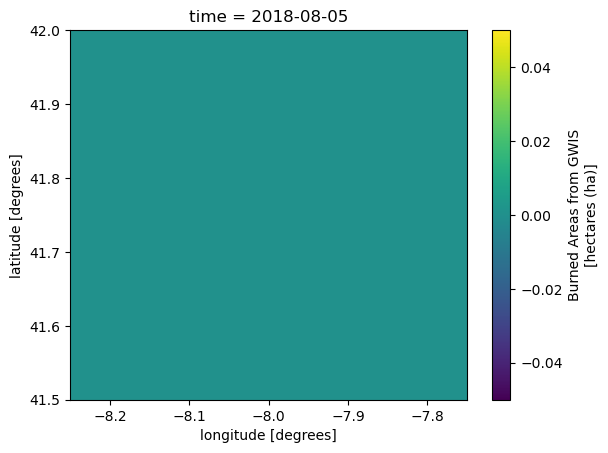

In [27]:
gwis_aoi = gwis.sel(latitude=lat_slice,longitude=lon_slice).sel(time=time_oi,method="nearest")
gwis_aoi.plot()


## Another Example...
We will now do something a bit more complicated and fetch data using pystac to search through the earth-search.aws.element84.com/v1 STAC API endpoint. As mentioned in the [STAC and Data Access guide](../earthcode101/stac_and_data_access.ipynb), the STAC API provides us with endpoints to query STAC collections.

There is an ecosystem of libraries that implement STAC standards (pystac, odc-stac, stackstac, etc..) that allow us to analyse, load and use data described in STAC. We will briefly explore in the following cells below.

As a first step, we will open a catalog with the pystac library: https://earth-search.aws.element84.com/v1 This catalog contains STAC collections of various datasets (such as sentinel-1 and sentinel-2 data) in cloud optimised formats (COGs in this case) - see https://earth-search.aws.element84.com. for more details. With these formats we are able to use the assets using cloud-native access patterns (see https://guide.cloudnativegeo.org/cookbooks/ for more details).

Note that a STAC endpoint like the one below, only returns STAC items and not the actual data. The STAC items returned have Assets defined which link to the actual data (and provide metadata).

In [28]:
import pandas as pd

fire_date_t = pd.to_datetime(time_oi) # get the date of the forest fire and a the dates before and after it
week_before = (fire_date_t - timedelta(days=7))
week_after = (fire_date_t + timedelta(days=7))

In [29]:
print(week_before.date(), "---" , week_after.date())

2018-07-25 --- 2018-08-08


In [30]:
catalog = pystac_client.open("https://earth-search.aws.element84.com/v1")
chunk={} # <-- use dask
res=10 # 10m resolution

In the next step we will do two things:

**1.** Search for multiple cloudless sentinel-2 satellite images within a month of our pre-fire (week_before) date. The STAC API allows us to do a couple of things in a simple API call:
- We can define an arrea of interest (bbox) and search for items that cover this region
- We can subset for the time of interest as well (datetime)
- We can define custom querries over implemented STAC extensions. For example, the Sentinel STAC collection we are querrying implements the eo STAC extension, and defines cloud_cover - this allows us to search for quality assets with minimal cloudy pixels

This will return the relevant STAC items - which contain assets that point to our data of interest. We now need to load this data into a dataarray to start analysing it.

**2.** Note that in the above step, we only have items that point to some data - this data can be tiff, zarr, netcdf, COG, or other SpatioTemporal asset data. In our case, the element84 endpoint points to the data collection of  *https://registry.opendata.aws/sentinel-2-l2a-cogs/* - the format of our data is cloud-optimized GeoTiff. A cloud-friendly format such as this enables us cloud-native access patterns, such as easily fetching only our area of interest (as opposed to several tiff files and manually subsetting them after downloading).

Libraries such as odc-stac integrate with STAC standards and allow us to load data as well as leveraging the cloud-optimised formats. For example, in the cell below we define how we want to transform/load our data by:
- Passing the STAC item (or multiple items) we want to load
- defining a particular chunk size (the passed {} asks for the data to be automatically chunked as it is originally);
- We can request only the spectral bands of interest, in this case nir and swir22, to reduce the amount of data that we fetch.
- We can define a resolution to retrieve the data at, note that this will also resample automatically. For example the nir band data has a 10m resolution, but the swir22 - 20m resolution.
- There are multiple other options as well, such as defining in which projection we want our data in. More information can be found at: https://odc-stac.readthedocs.io/en/latest/_api/odc.stac.load.html


In [31]:
# STAC search for relevant items
week_before_start = (week_before - timedelta(days=30))
time_range_start = str(week_before_start.date()) + "/" + str(week_before.date())

query1 = catalog.search(
    collections=["sentinel-2-l2a"], datetime=time_range_start, limit=100,
    bbox=bbox, query={"eo:cloud_cover": {"lt": 20}}
)

items = list(query1.items())
print(f"Found: {len(items):d} datasets")

Found: 6 datasets


In [32]:
# plot all the STAC assets
poly_pre = gpd.GeoSeries([shapely.Polygon(item.geometry['coordinates'][0]) for item in items], name='geometry', crs='epsg:4236')
poly_pre.explore()

In [33]:
prefire_ds = stac_load(
    items,
    bands=("nir", "swir22"),
    chunks=chunk,  # <-- use Dask
    resolution=res,
    crs="EPSG:32629",
        groupby="datetime",
    bbox=bbox,
)
prefire_ds = prefire_ds.mean(dim="time")
prefire_ds

<xarray.Dataset> Size: 95MB
Dimensions:      (y: 2800, x: 2112)
Coordinates:
  * y            (y) float64 22kB 4.637e+06 4.636e+06 ... 4.609e+06 4.609e+06
  * x            (x) float64 17kB 5.726e+05 5.726e+05 ... 5.937e+05 5.937e+05
    spatial_ref  int32 4B 32629
Data variables:
    nir          (y, x) float64 47MB dask.array<chunksize=(2800, 2112), meta=np.ndarray>
    swir22       (y, x) float64 47MB dask.array<chunksize=(2800, 2112), meta=np.ndarray>